# Overview

This notebook demonstrates applying several path plotting algorithms and optimizing them to be suitable for translating to motor commands for the MASCCOT robot.  Our input data is a portion of the campus map that was acquired from the OpenStreetMap project.

## Helpful Links

* Intro to path planning: http://correll.cs.colorado.edu/?p=965.
* Understanding K-means visually: http://tech.nitoyon.com/en/blog/2013/11/07/k-means/
* Manhattan vs Euclidean vs Chebyshev distance: https://lyfat.wordpress.com/2012/05/22/euclidean-vs-chebyshev-vs-manhattan-distance/

In [2]:
# used to automatically display images/plots after plot.imshow(img)
%matplotlib inline

# used for interactive widgets against CV algorithms for testing purposes
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets

import numpy as np
import cv2
import matplotlib.pyplot as plt

import networkx as nx

import scipy.interpolate

# a convenience method for displaying images in BGR format correctly
display_img = lambda img, convert = True: plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if convert else img)

In [3]:
# Increase the size of the matplotlib figures
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)

In [4]:
from lxml import etree
import re

class KmlParser:
    def __init__(self, root):
        self.root_dir = root
    
    @property
    def root(self):
        return self.root_dir
    
    @root.setter
    def root(self, root):
        self.root_dir = root
    
    # Parsed a KML file from the OSM project and returns a numpy image and the GPS map boundaries as a tuple
    def parse(self, filename, convert_to_RGB = True):
        tree = etree.parse(self.root + filename)
        root = tree.getroot()
        
        # parse the KML file for the location of the map image and the GPS boundaries
        ground_overlay = root.getchildren()[0]
        (map_pic_xml, latlong) = ground_overlay.getchildren()
        map_file = map_pic_xml.getchildren()[0].text
        map_bounds = dict([(re.sub('{.+}', '', child.tag), float(child.text)) for child in latlong.getchildren()])
        
        del map_bounds['rotation']
        
        # actually parse the image into a numpy-readable array for CV processing
        if convert_to_RGB:
            map_np = cv2.imread(self.root_dir + map_file, cv2.COLOR_BGR2RGB)
        else:
            map_np = cv2.imread(self.root_dir + map_file)
            
        return map_np, map_bounds

In [5]:
processing_area = 'dvc_quad'

if processing_area == 'engi_quad':
    dataset_root = 'dataset/engi-area/'
    kml_file = 'lrp162085988-190308-2300.kml'
elif processing_area == 'dvc_quad':
    dataset_root = 'dataset/dvc-quad-area/'
    kml_file = 'kdq161545710-190302-1656.kml'
else:
    raise Exception('Unknown processing area!')

In [6]:
kml_processor = KmlParser(dataset_root)
original_map, map_coords = kml_processor.parse(kml_file)

In [7]:
map_coords

{'north': 37.969643382155,
 'south': 37.968019440356,
 'east': -122.06977844238,
 'west': -122.07183837891}

In [8]:
class GpsPixelConverter:
    # Note: Image coordinates start from top left while
    # GPS coordinates start from bottom left
    def __init__(self, img_bounds, gps_bounds):
        self.img_height = img_bounds[1]
        self.img_length = img_bounds[0]
        
        # GPS boundaries
        self.gps_bounds = gps_bounds
    
    # longitute = x = length, latitute = y = height
    # Note: interp for north/south is flipped since the origin points
    # for image and GPS are flipped for the y-axis
    def to_img(self, long, lat):
        img_x = np.interp(long, [self.gps_bounds['west'], self.gps_bounds['east']], [0, self.img_length])
        img_y = np.interp(lat, [self.gps_bounds['south'], self.gps_bounds['north']], [0, self.img_height])
        return (int(img_x), int(img_y))
    
    def to_gps(self, img_x, img_y):
        long = np.interp(img_x, [0, self.img_length], [self.gps_bounds['west'], self.gps_bounds['east']])
        lat = np.interp(img_y, [0, self.img_height], [self.gps_bounds['south'], self.gps_bounds['north']])
        return (long, lat)

In [9]:
map_img_size = list(original_map.shape)[:2][::-1]
print(map_img_size)

coord_conv = GpsPixelConverter(map_img_size, map_coords)

print('\nTesting to_gps()\n')

print(coord_conv.to_img(*coord_conv.to_gps(0, 0)))
print(coord_conv.to_img(*coord_conv.to_gps(0, map_img_size[1])))
print(coord_conv.to_img(*coord_conv.to_gps(map_img_size[0], map_img_size[1])))
print(coord_conv.to_img(*coord_conv.to_gps(map_img_size[0], 0)))
print(coord_conv.to_img(*coord_conv.to_gps(map_img_size[0] / 2, map_img_size[1] / 2)))

print('\nTesting to_img()\n')

print(coord_conv.to_gps(*coord_conv.to_img(map_coords['west'], map_coords['north'])))
print(coord_conv.to_gps(*coord_conv.to_img(map_coords['east'], map_coords['north'])))
print(coord_conv.to_gps(*coord_conv.to_img(map_coords['east'], map_coords['south'])))
print(coord_conv.to_gps(*coord_conv.to_img(map_coords['west'], map_coords['south'])))

[768, 768]

Testing to_gps()

(0, 0)
(0, 768)
(768, 768)
(768, 0)
(384, 384)

Testing to_img()

(-122.07183837891, 37.969643382155)
(-122.06977844238, 37.969643382155)
(-122.06977844238, 37.968019440356)
(-122.07183837891, 37.968019440356)


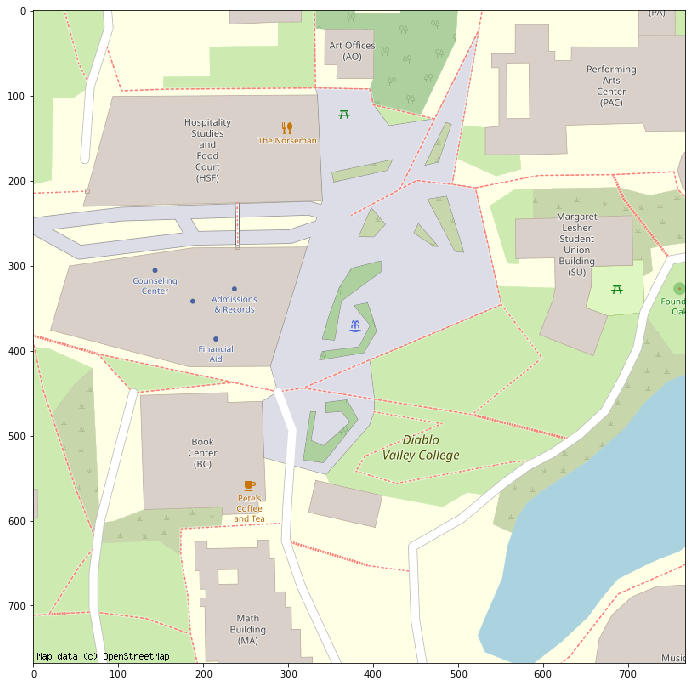

In [10]:
display_img(original_map)

In [11]:
# Returns all found color centers from greatest population to least
def get_color_centers(centers, labels):
    _, center_counts = np.unique(labels, return_counts=True)
    centers_map = list(zip(centers, center_counts))
    sorted_centers = sorted(centers_map, key=lambda item: item[1], reverse=True)
    return np.array(sorted_centers)

# Reduces the color space to a given number of colors using K-means, then
# plucks the allowed list of color centers and discards the rest

# Visual demo for K-means: http://tech.nitoyon.com/en/blog/2013/11/07/k-means/
# OpenCV documentation: https://docs.opencv.org/4.1.0/d1/d5c/tutorial_py_kmeans_opencv.html
def kmeans_image(image, num_colors):
    # Convert the image to a list of color pixels
    colors_arr = np.float32(image.reshape((-1,3)))

    # Stop algorithm if either the max number of iterations or required accuracy is reached
    termination_criteria = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER
    max_iterations = 10         # Maximum number of iterations
    required_acc = 10000.0      # Required accuracy

    criteria = (termination_criteria, max_iterations, required_acc)
    compactness, labels, centers = cv2.kmeans(
        colors_arr,             # Input data
        num_colors,             # Number of categories
        None,                   # "bestLabels", which is unused
        criteria,               # K-means parameters, as discussed above
        10,                     # Number of attempts
        cv2.KMEANS_PP_CENTERS   # Optimal initial centers are calculated using kmeans++ center initialization
                                # https://en.wikipedia.org/wiki/K-means++#Improved_initialization_algorithm
    )

    # Map the color center and corresponding indicies back into the new flattened image
    centers_ints = np.uint8(centers)
    cleaned_img_1d = centers_ints[labels.flatten()]

    # now reformat the image to 2D
    kimage = cleaned_img_1d.reshape((image.shape))

    # Get the sorted centers to return for further processing
    color_centers_info = get_color_centers(centers_ints, labels)
    color_centers = color_centers_info[:, 0]

    return (kimage, color_centers)

In [12]:
num_categories_profile = {
    'engi_quad': 13,
    'dvc_quad': 12
}

(simplified_map, color_centers) = kmeans_image(original_map, num_categories_profile[processing_area])

In [13]:
color_centers

array([array([200, 207, 216], dtype=uint8),
       array([228, 255, 255], dtype=uint8),
       array([176, 235, 204], dtype=uint8),
       array([231, 221, 221], dtype=uint8),
       array([222, 210, 170], dtype=uint8),
       array([171, 211, 199], dtype=uint8),
       array([157, 199, 171], dtype=uint8),
       array([254, 254, 254], dtype=uint8),
       array([198, 241, 222], dtype=uint8),
       array([136, 153, 245], dtype=uint8),
       array([113, 126, 130], dtype=uint8),
       array([46, 70, 60], dtype=uint8)], dtype=object)

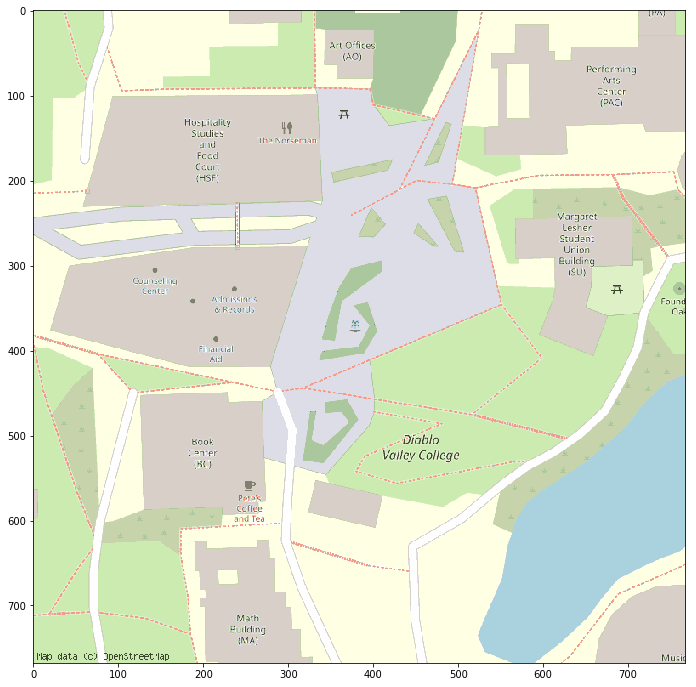

In [14]:
display_img(simplified_map)

In [15]:
# Removes the unwanted colors that aren't in the allowed list of colors (if given)
def retain_colors(kimage, color_centers, allowed_colors):
    retained_img = kimage.copy()

    unallowed_colors = [center for center in color_centers if not np.any(allowed_colors[:] == center)]
    
    # for all unallowed colors, make them black
    for center in unallowed_colors:
        retained_img[np.where((retained_img == center).all(axis = 2))] = [0, 0, 0]

    return retained_img

In [16]:
color_center_profiles = {
    'engi_quad': [color_centers[2]],
    'dvc_quad': [color_centers[3], color_centers[7]]
}

allowed_centers = color_center_profiles[processing_area]

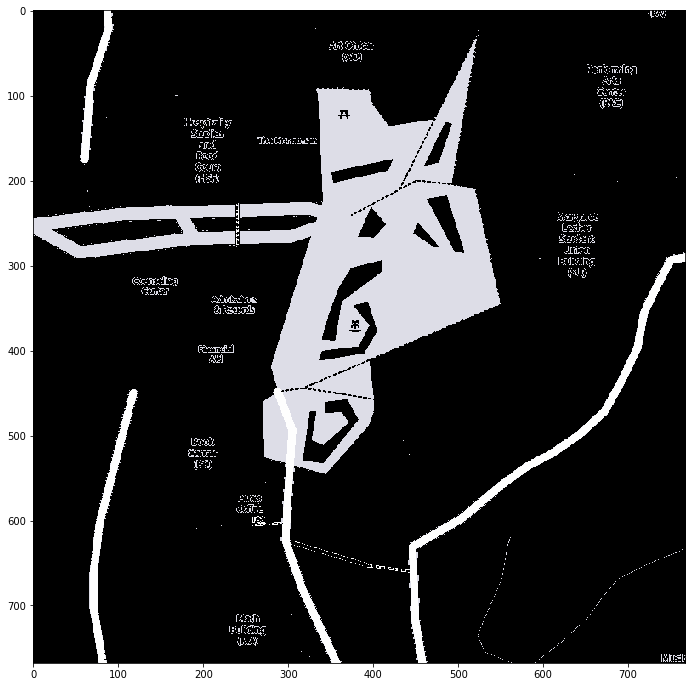

In [17]:
stripped_map = retain_colors(simplified_map, color_centers, allowed_centers)
display_img(stripped_map)

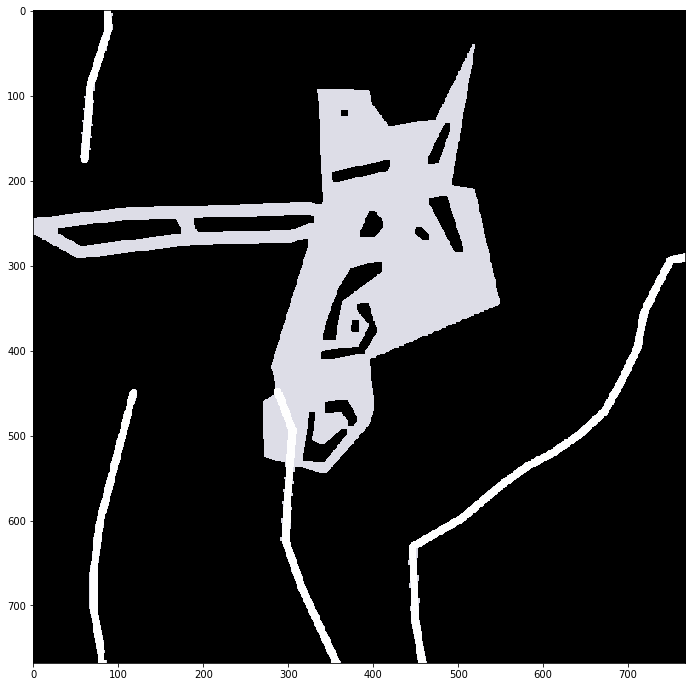

In [18]:
kernel33 = np.ones((3,3), np.uint8)
kernel55 = np.ones((5,5), np.uint8)
kernel77 = np.ones((7,7), np.uint8)

def clean_engi_quad(img_map):
    img_map_copy = img_map.copy()
    
    # get rid of the text and thin lines
    img_map_copy = cv2.morphologyEx(img_map_copy, cv2.MORPH_OPEN, kernel33)
    
    return img_map_copy

def clean_dvc_quad(img_map):
    img_map_copy = img_map.copy()
    
    # get rid of the text and thin lines
    img_map_copy = cv2.morphologyEx(img_map_copy, cv2.MORPH_OPEN, kernel33)
    
    # close the small holes
    img_map_copy = cv2.morphologyEx(img_map_copy, cv2.MORPH_CLOSE, kernel77)
    
    return img_map_copy

cleaning_profiles = {
    'engi_quad': clean_engi_quad,
    'dvc_quad': clean_dvc_quad
}

cleaned_map = cleaning_profiles[processing_area](stripped_map)
display_img(cleaned_map)

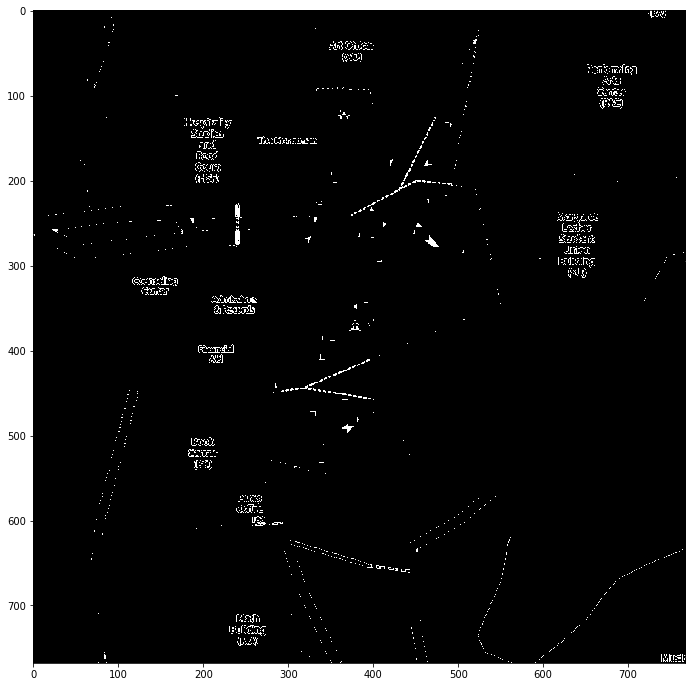

In [19]:
# Difference before and after opening operation
display_img((stripped_map - cleaned_map) | (cleaned_map - stripped_map))

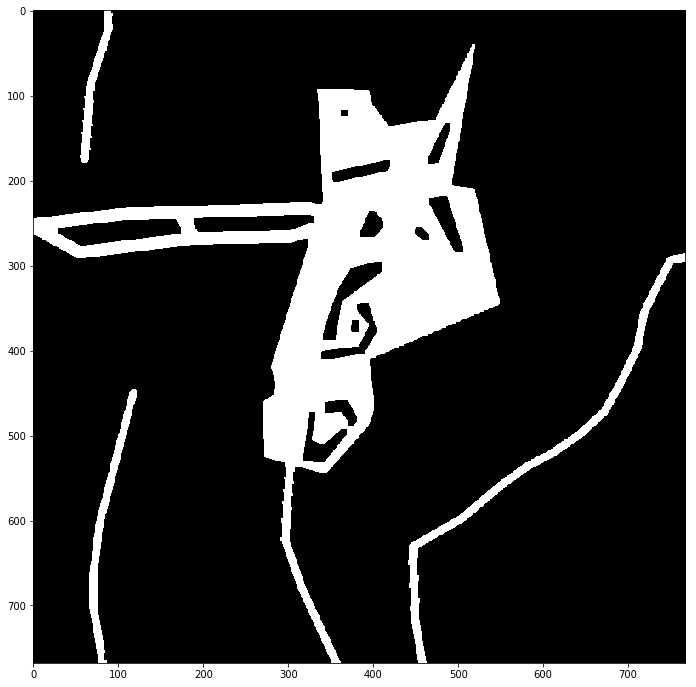

In [20]:
# Compress any redundant information and get a black/white image, with black == 0 and white == 1
flattened_map = np.average(cleaned_map, axis=2).astype(np.uint8)
bw_map = cv2.threshold(flattened_map, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
display_img(bw_map)

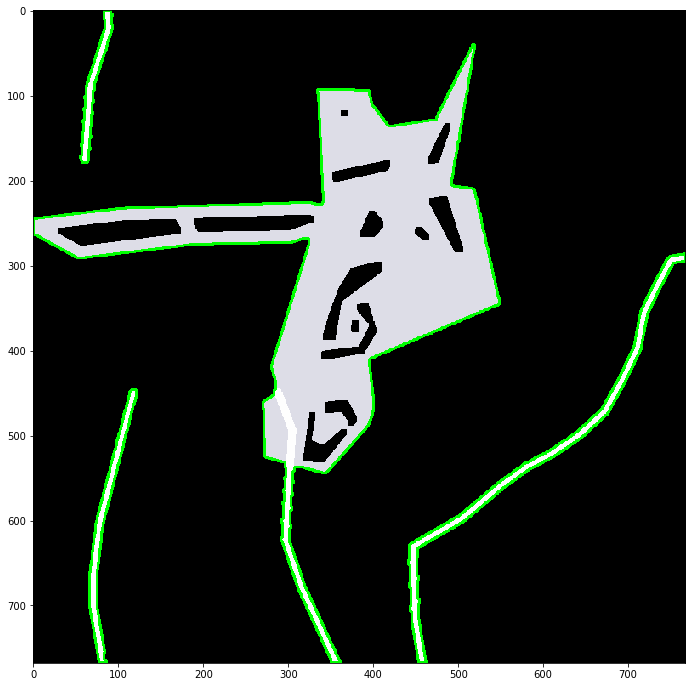

In [21]:
def get_contour_areas(bw_map, clean_map):
    path_cnts = cv2.findContours(bw_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    
    cnt_area_records = []

    # For each list of contour points...
    for i in range(len(path_cnts)):
        # Create a mask image that contains the contour filled in
        area_img = np.zeros_like(clean_map)
        cv2.drawContours(area_img, path_cnts, i, color=255, thickness=-1)

        # Access the image pixels and create a 1D numpy array then add to list
        (rows, cols, _) = np.where(area_img == 255)
        area_count = len(rows) # == len(cols)
        
        cnt_area_records.append({
            'pixel_coords': (rows, cols),
            'contour': path_cnts[i],
            'area': area_count
        })
    
    # sort all pixel records from most area to least
    sorted_area_records = sorted(cnt_area_records, key=lambda item: item['area'], reverse=True)
    final_contour_areas = np.array(sorted_area_records)
    
    # Draw all the found contour areas
    drawn_areas = cv2.drawContours(clean_map.copy(), path_cnts, -1, (0, 255, 0), 2)
    
    return final_contour_areas, drawn_areas

contour_areas, drawn_areas = get_contour_areas(bw_map, cleaned_map)
display_img(drawn_areas)

Binary image shape: (768, 768)


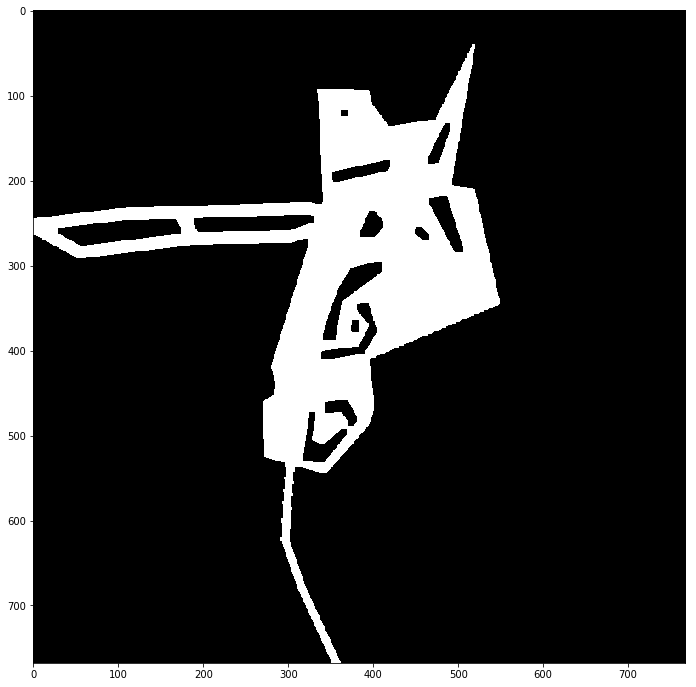

In [22]:
bw_map_copy = bw_map.copy()

# Keep the largest contour area and set the rest to black
for rec in contour_areas[1:]:
    rows, cols = rec['pixel_coords']
    bw_map_copy[rows, cols] = 0

binary_map = bw_map_copy.clip(max=1)

print('Binary image shape:', binary_map.shape)
display_img(bw_map_copy)

In [22]:
if processing_area == 'engi_quad':
    engi_cnt = contour_areas[0]['contour']
    arc_len = cv2.arcLength(engi_cnt, True)
    
    polyDP_array = []
    for mult in range(0, 100):
        polyDP_array += [cv2.approxPolyDP(engi_cnt, mult / 100 * arc_len, True)]
    
    approx_poly = cv2.approxPolyDP(engi_cnt, 0.04 * arc_len, True)
    print(np.vectorize(len)(np.array(polyDP_array)))
    print(approx_poly)
    
    (x, y, w, h) = cv2.boundingRect(approx_poly)
    print((x, y, x+w, y+h))
    
    cmap_copy = cleaned_map.copy()
    cv2.rectangle(cmap_copy, (x, y), (x + w, y + h), (255, 0, 0), 2)
    display_img(cmap_copy)

In [23]:
# Used for converting an image's coordinates and neighbors into an undirected graph
# for use with computing the shortest path from point A to point B

# Note that the coordinates are specified as (y, x), in accordance to the internal structure
# of numpy images read from OpenCV
class Image2Graph:
    def __init__(self, input_img, weight_mask = None):
        self.image = input_img
        self.weights = weight_mask
        
        if self.weights is not None and not np.array_equal(input_img.shape, weight_mask.shape):
            raise Exception('Input image and weight mask dimensions do not match!')
        
        self.width = self.image.shape[0]
        self.height = self.image.shape[1]
    
    def to_index(self, x, y):
        return y * self.height + x
    
    def to_coordinates(self, index):
        x = index % self.height
        y = index // self.height
        return x, y
    
    def neighbor_generator(self, x, y, n_range = 1):
        # generate 1D field of numbers from [-field_range, field_range]
        coord_nums = range(-n_range, n_range + 1)
        
        # get the meshgrid to generate the list of possible corods
        x_mesh, y_mesh = np.meshgrid(coord_nums, coord_nums)
        
        # zip the two 2D arrays as coordinate pairs
        paired_coords = np.array([list(zip(x, y)) for x, y in zip(x_mesh, y_mesh)])
        
        # reshape the 3D array as a list of coordinates (2D)
        all_neighbors = paired_coords.reshape((2 * n_range + 1) ** 2, 2)
        
        # don't include (0, 0), since any point cannot be a neighbor to itself
        all_neighbors = np.delete(all_neighbors, len(all_neighbors) // 2, axis=0)
        
        # shift the coords relative to (x, y)
        all_neighbors += [x, y]
        
        return all_neighbors
    
    def get_neighbors(self, x, y, n_range):
        possible_neighbors = self.neighbor_generator(x, y, n_range)
        valid_neighbors = []
        
        for (x, y) in possible_neighbors:
            # Ignore neighbors that exceed the boundaries of the image
            if x >= self.width or y >= self.height:
                continue
            if x < 0 or y < 0:
                continue
            
            # Only add neighbors that the robot can travel on
            if self.image[y, x] == 1:
                valid_neighbors += [(x, y)]

        return valid_neighbors
    
    # The graph generation will take quite a long time, since it has to go through
    # each non-zero pixel, find its neighbors, then add those as edges to the graph

    # The time complexity for any given image of size m x n, while searching for a maximum
    # of k neighboring pixels should be roughly O(m * n * k) for the worst case scenario

    # The space complexity for the nodes is O(m * n) while for the edges, it's roughly
    # O(m * n * k / 2) or exactly half the time complexity.
    def generate_graph(self, use_weights = None):
        if use_weights is None:
            use_weights = self.weights is not None
        
        num_ops = 0
        
        # Get valid areas that the robot can travel on
        non_zero_coords = list(zip(*np.where(self.image == 1)))
        max_weight = np.max(self.weights)
        img_graph = nx.Graph()

        for (cy, cx) in non_zero_coords:
            # Generate a list of neighboring pixels relative to (cx, cy)
            neighbors = self.get_neighbors(cx, cy, 1)
            for neighbor in neighbors:
                # Get the corresponding weight if a weight mask was specified
                weight = 1 if not use_weights else max_weight - self.weights[cy, cx]
                
                # Add the current coordinate and its neighbor as an edge
                img_graph.add_edge(
                    self.to_index(cx, cy),
                    self.to_index(*neighbor),
                    weight = weight
                )
                
                num_ops += 1
        
        num_nodes = img_graph.number_of_nodes()
        num_edges = img_graph.number_of_edges()

        return img_graph, (num_nodes, num_edges, num_ops)

Minimum value of distance map: 0.0
Maximum value of distance map: 1.0
Average value of distance map: 0.12137983212305767


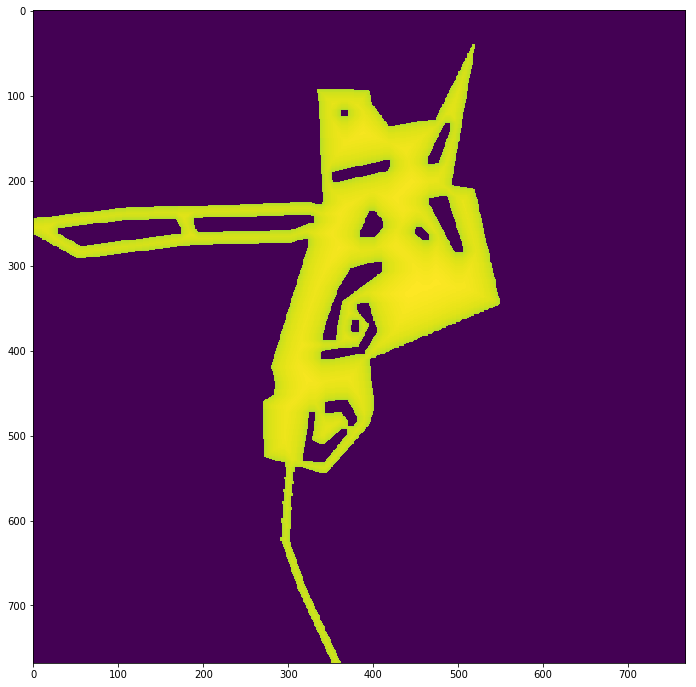

In [24]:
# Distance transform: https://docs.opencv.org/4.1.0/d7/d1b/group__imgproc__misc.html#ga8a0b7fdfcb7a13dde018988ba3a43042
# Used for prioritizing areas that are farther away from the edge to help the robot not fall
def dist_transform(input_img, transform_params):
    transformed_img = cv2.distanceTransform(binary_map, *transform_params)
    
    # Map the transformed image to a scale of [0, 1]
    # - near 0 ~= closer towards the sea
    # - near 1 ~= closer inland
    # This is important for when we need to transform those set of values
    # to place more weight for pixels near the edges
    mapped_result = np.interp(
        transformed_img,
        (transformed_img.min(), transformed_img.max()),
        (0, 1)
    )
    
    return mapped_result

# Read here for more info about the various distance equations: https://lyfat.wordpress.com/2012/05/22/euclidean-vs-chebyshev-vs-manhattan-distance/
# cv2.DIST_L1 == Manhattan distance
# cv2.DIST_L2 == Euclidean distance
# cv2.DIST_C == Checkerboard distance

dist_map = dist_transform(binary_map, (cv2.DIST_L1, cv2.DIST_MASK_5))
dist_map **= .03    # This gives more emphasis for pixels near the edge and allows the robot
                    # to not be gravitated towards large open areas when calculating a path

                    # We use x^n where 0 < n < 1 to give more priority for near-edged pixels
                    # and bring them almost equal to the far-edged pixels, whose weights are
                    # closer to 1

print('Minimum value of distance map:', np.min(dist_map))
print('Maximum value of distance map:', np.max(dist_map))
print('Average value of distance map:', np.mean(dist_map))

display_img(dist_map, False)

In [25]:
def print_complexity_analysis(cmplx_analysis, generated):
    (num_nodes, num_edges, num_ops) = cmplx_analysis
    if generated:
        print('Number of generated nodes:', num_nodes)
        print('Number of generated edges:', num_edges)
        print('Number of operations done:', num_ops)
    else:
        print('Number of calculated nodes:', num_nodes)
        print('Number of calculated edges:', num_edges)
        print('Number of approx operations:', num_ops)

In [26]:
def calculate_spacetime_complexity(length, width):
    center_max_neighbors = 8
    side_max_neighbors = 5
    corner_max_neighbors = 3
    
    # Calculate exact time complexity for graph generation algorithm
    center_pixels = (length - 2) * (width - 2) * center_max_neighbors
    side_pixels = (2 * (length - 2) + 2 * (width - 2)) * side_max_neighbors
    corner_pixels = 4 * corner_max_neighbors
    total_ops_done = center_pixels + side_pixels + corner_pixels
    
    # Calculate exact space complexity for nodes
    calculated_nodes = length * width
    
    # Calculate exact space complexity for edges
    calculated_edges = int(total_ops_done / 2)
    
    return (calculated_nodes, calculated_edges, total_ops_done)

In [27]:
img2graph = Image2Graph(binary_map, dist_map)
map_graph, gen_analysis = img2graph.generate_graph(use_weights = True)

In [28]:
calc_analysis = calculate_spacetime_complexity(*binary_map.shape)
print_complexity_analysis(calc_analysis, False)
print()
print_complexity_analysis(gen_analysis, True)

Number of calculated nodes: 589824
Number of calculated edges: 2354690
Number of approx operations: 4709380

Number of generated nodes: 75824
Number of generated edges: 296020
Number of operations done: 592040


In [29]:
debug_all_white_img = False

if debug_all_white_img:
    all_white_img = np.ones((binary_map.shape))
    print(all_white_img.shape)

    img2graph_tmp = Image2Graph(all_white_img)
    map_graph_tmp, tmp_gen_analysis = img2graph_tmp.generate_graph(use_weights = False)
    
    tmp_calc_analysis = calculate_spacetime_complexity(*all_white_img.shape)
    print_complexity_analysis(tmp_calc_analysis, False)
    print()
    print_complexity_analysis(tmp_gen_analysis, True)

In [30]:
from time import time

test_i2g_times = False

def img2graph_complexity_analysis(size, debug = False):
    all_whites = np.ones((size, size))
    length, width = all_whites.shape
    
    img2graph_test = Image2Graph(all_whites)
    
    start = time()
    all_whites_graph, test_gen_analysis = img2graph_test.generate_graph(False)
    end = time()
    print_complexity_analysis(test_gen_analysis, generated = False)
    
    duration = end - start
    
    if debug:
        test_calc_analysis = calculate_spacetime_complexity(length, width)
        print_complexity_analysis(test_calc_analysis, generated = False)

        print('Graph generation time:', duration)
        
    return duration

def test_img2graph_times(max_size, debug = False):
    times = []
    for size in range(1, max_size + 1):
        times += [img2graph_complexity_analysis(size, debug)]
        if size % 10 == 0:
            print(size)
    plt.plot(range(1, max_size + 1), times)

if test_i2g_times:
    test_img2graph_times(200, not True)

In [31]:
# Used for safely evaluating pythonic expressions
# https://docs.python.org/3/library/ast.html#ast.literal_eval
from ast import literal_eval

# Used for generating attractive colors
# https://github.com/davidmerfield/randomColor
from randomcolor import RandomColor

def get_random_color(luminosity = 'bright'):
    rand_color = RandomColor()
    
    # Since rand_color.generate returns a string in the form of 'rgb(100, 175, 255)'
    # We need to clean that string and convert it to a tuple, which is what OpenCV
    # accepts as valid color arguments for drawing
    color_str = rand_color.generate(luminosity = luminosity, format_ = 'rgb')
    return literal_eval(color_str[0][3:])

In [32]:
def draw_path_points(img, path, thickness, is_cnt = True):
    drawn_img = img.copy()
    color = get_random_color('light')
    
    prev_coord = None
    for coord in path:
        actual_coord = tuple(coord[0]) if is_cnt else coord
        cv2.circle(drawn_img, actual_coord, thickness, color, cv2.FILLED)
    return drawn_img

def draw_path_lines(img, path, thickness, is_cnt = True):
    drawn_img = img.copy()
    color = get_random_color('dark')
    
    prev_coord = None
    for coord in path:
        actual_coord = tuple(coord[0]) if is_cnt else coord
        if prev_coord is not None:
            actual_prev_coord = tuple(prev_coord[0]) if is_cnt else prev_coord
            cv2.line(drawn_img, actual_prev_coord, actual_coord, color, thickness)
        prev_coord = coord
    return drawn_img

In [33]:
def pick_random_points(img):
    rows, cols = np.nonzero(img)
    valid_points = np.array(list(zip(cols, rows)))
    num_points, point_len = valid_points.shape
    
    p1_ind = np.random.randint(num_points)
    p2_ind = np.random.randint(num_points)

    (x1, y1) = valid_points[p1_ind]
    (x2, y2) = valid_points[p2_ind]

    return ((x1, y1), (x2, y2))

(459, 226) to (363, 445)
Starting coords: (-122.07060724496824, 37.96849731906248)
Ending coords: (-122.0708647370345, 37.9689603962161)
(458, 226)
(362, 444)


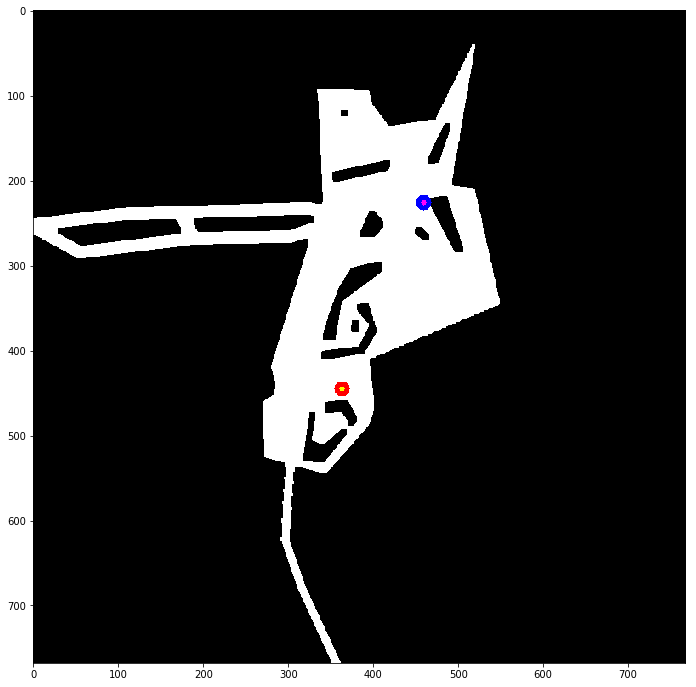

In [34]:
(start, end) = pick_random_points(bw_map_copy)
print(start, 'to', end)

print('Starting coords:', coord_conv.to_gps(*start))
print('Ending coords:', coord_conv.to_gps(*end))

print(coord_conv.to_img(*coord_conv.to_gps(*start)))
print(coord_conv.to_img(*coord_conv.to_gps(*end)))

bw_copy_mod = cv2.cvtColor(bw_map_copy.copy().astype(np.uint8), cv2.COLOR_GRAY2BGR)

dot_size = 9
cv2.circle(bw_copy_mod, start, dot_size, (255, 0, 0), cv2.FILLED)
cv2.circle(bw_copy_mod, start, dot_size // 3, (255, 0, 255), cv2.FILLED)

cv2.circle(bw_copy_mod, end, dot_size, (0, 0, 255), cv2.FILLED)
cv2.circle(bw_copy_mod, end, dot_size // 3, (0, 255, 255), cv2.FILLED)

display_img(bw_copy_mod)

In [35]:
# Uncomment this line to benckmark the path planning function itself
# %%timeit

nx_path = nx.shortest_path(
    map_graph,
    img2graph.to_index(*start),
    img2graph.to_index(*end),
    weight='weight'
)

In [36]:
# Reverse lookup the coordinates in the image graph
nx_path_original = [img2graph.to_coordinates(index) for index in nx_path]
print(len(nx_path_original))

222


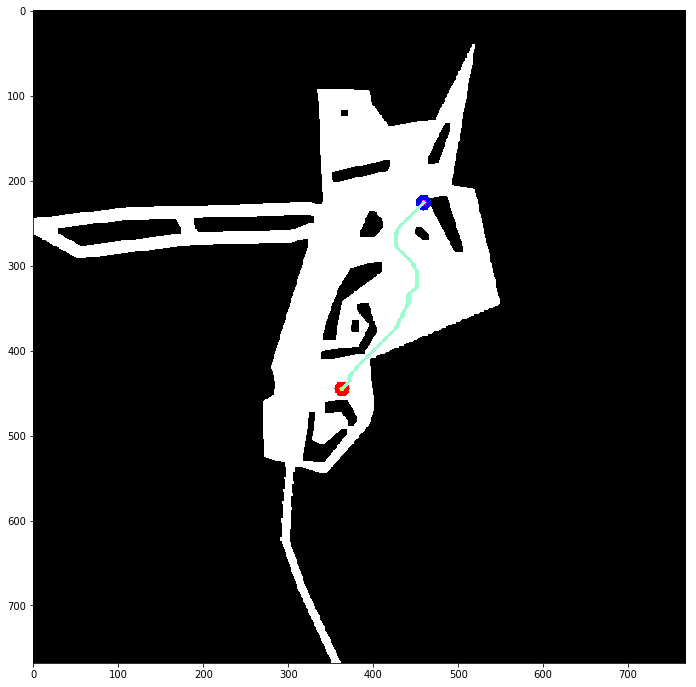

In [37]:
map_with_crude_path = draw_path_points(
    bw_copy_mod,
    nx_path_original,
    thickness = 2,
    is_cnt = False
)

display_img(map_with_crude_path)

In [38]:
# The given path so far is overly specified, so let's reduce the number of waypoints
# needed for the robot to reach to without compromising the general shape of the path itself

# We'll do this by taking advantage of the contour creation functions in OpenCV, mainly approxPolyDP
# for generating an approximated line path from the points, based on the Douglas-Peucker algorithm
# Wiki: http://en.wikipedia.org/wiki/Ramer-Douglas-Peucker_algorithm

In [39]:
# Convert a list of coordinates into a contour for use with contour calculations
def path2contour(path):
    path_cnt = np.array([[point] for point in path]).astype(np.int32)
    return path_cnt

In [40]:
nx_path_cnt = path2contour(nx_path_original)

In [41]:
cv2.arcLength(nx_path_cnt, False)

281.4751765727997

In [42]:
# Uses the Douglas-Peucker algorithm (approxPolyDP) to generate a series of simplified paths
# and picks the best one by taking the arc lengths of the simplified paths and testing if they
# are within a maximum error percentage (max_error). The best one will have the greatest
# error percentage that's lower than the maximum error percentage.
def simplify_path_polydp(orig_path_cnt, max_error, resolution = 1000 * 1000):
    arc_len = cv2.arcLength(orig_path_cnt, False)
    max_tol = arc_len - max_error * arc_len
    seen_path_lengths = []

    for mult in range(0, resolution):
        epsilion = mult / resolution * arc_len
        simplified_path = cv2.approxPolyDP(orig_path_cnt, epsilion, False)
        path_len = len(simplified_path)
        
        if path_len == 2:
            break
        
        if path_len not in seen_path_lengths:
            seen_path_lengths += [path_len]
            simple_arc_len = cv2.arcLength(simplified_path, False)
            if simple_arc_len < max_tol:
                return (simplified_path, epsilion / arc_len)
    
    return (simplified_path, epsilion / arc_len)

# Explanation of B-spline interpolation:
# A spline is a "piecewise polynomial function", which means that it's a polynomial function that's
# represented by a series of n smaller functions defined by n time intervals. They are helpful for
# describing complex shapes and paths with mathematical functions and approximations.

# A basis spline (or B-spline) is like a basis vector from linear algebra: any given spline function can
# be represented as a linear combination of basis splines, just like how a vector can be represented by a
# linear combination of basis vectors.

# Uses spline interpolation to generate a series of points along the input path
def simplify_path_spline(contour, num_points):
    contour = np.array(contour)
    x,y = contour.T
    
    # Convert from numpy arrays to normal arrays
    x = x.tolist()[0]
    y = y.tolist()[0]
    
    # https://docs.scipy.org/doc/scipy-1.2.1/reference/generated/scipy.interpolate.splprep.html
    # Find the B-spline representation of an N-dimensional curve
    tck, u = scipy.interpolate.splprep([x,y], u=None, s=1.0, per=0)
    
    # https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.linspace.html
    # Returns n number of samples between [start, stop].
    u_new = np.linspace(u.min(), u.max(), num_points)
    
    # https://docs.scipy.org/doc/scipy-1.2.1/reference/generated/scipy.interpolate.splev.html
    # Evaluate a B-spline or its derivatives.
    x_new, y_new = scipy.interpolate.splev(u_new, tck, der=0)
    
    # Convert it back to numpy format for opencv to be able to display it
    res_array = [[[int(i[0]), int(i[1])]] for i in zip(x_new, y_new)]
    smoothened_path = np.asarray(res_array, dtype=np.int32)
    
    return smoothened_path

In [43]:
selected_path_05, ep_amt_05 = simplify_path_polydp(nx_path_cnt, .05)

In [44]:
selected_path_10, ep_amt_10 = simplify_path_polydp(nx_path_cnt, .1)

Length of simple path (w/ 5% max error): 5
Length of original path: 222


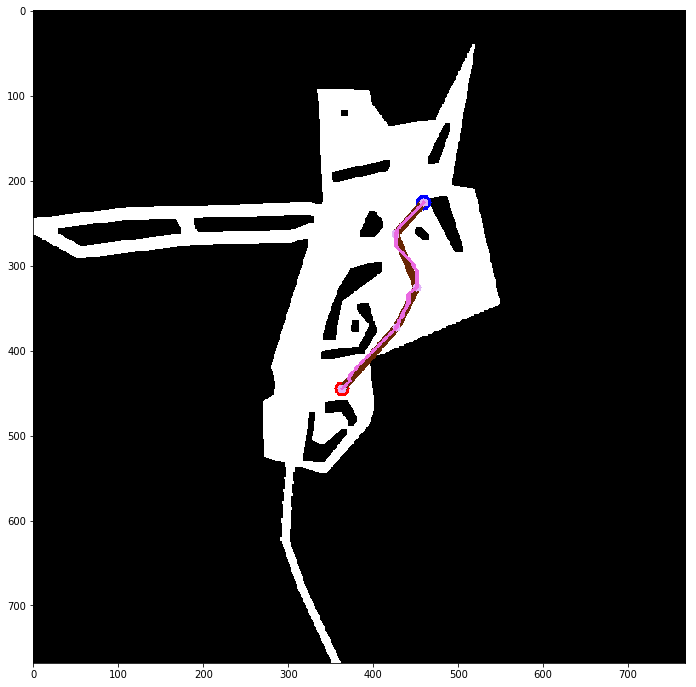

In [45]:
print('Length of simple path (w/ 5% max error):', len(selected_path_05))
map_with_simple_and_crude_path = draw_path_lines(
    bw_copy_mod,
    selected_path_05,
    thickness = 8,
    is_cnt = True
)

map_with_simple_and_crude_path = draw_path_points(
    map_with_simple_and_crude_path,
    selected_path_05,
    thickness = 5,
    is_cnt = True
)

print('Length of original path:', len(nx_path_original))
map_with_simple_and_crude_path = draw_path_points(
    map_with_simple_and_crude_path,
    nx_path_original,
    thickness = 2,
    is_cnt = False
)

display_img(map_with_simple_and_crude_path)

Length of simple path (w/ 10% max error): 3
Length of original path: 222


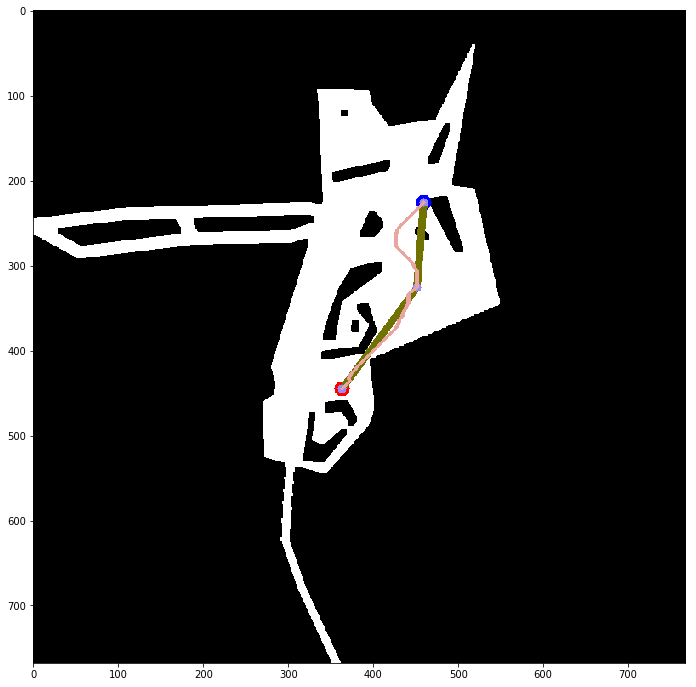

In [46]:
print('Length of simple path (w/ 10% max error):', len(selected_path_10))
map_with_simple_and_crude_path = draw_path_lines(
    bw_copy_mod,
    selected_path_10,
    thickness = 8,
    is_cnt = True
)

map_with_simple_and_crude_path = draw_path_points(
    map_with_simple_and_crude_path,
    selected_path_10,
    thickness = 5,
    is_cnt = True
)

print('Length of original path:', len(nx_path_original))
map_with_simple_and_crude_path = draw_path_points(
    map_with_simple_and_crude_path,
    nx_path_original,
    thickness = 2,
    is_cnt = False
)

display_img(map_with_simple_and_crude_path)

Number of points generated from spline: 28


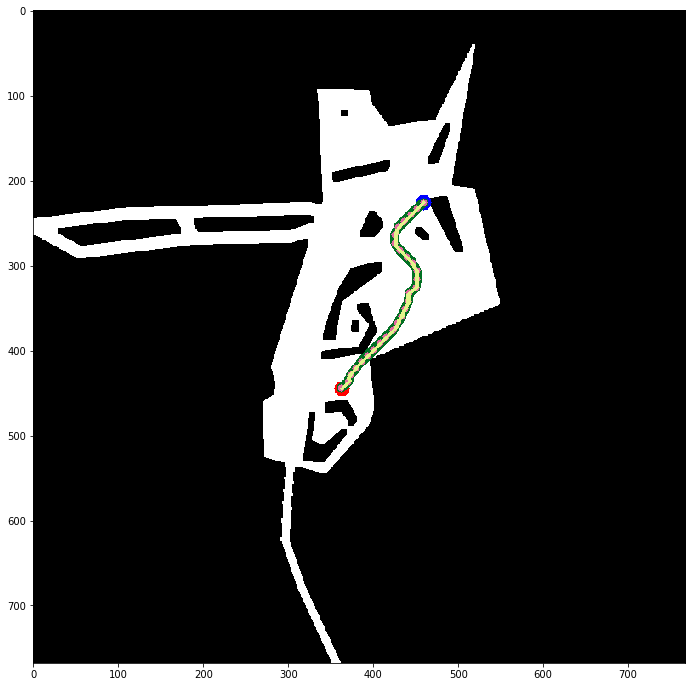

In [47]:
num_spline_points = int(cv2.arcLength(nx_path_cnt, False) // 10)
smoothened_path = simplify_path_spline(nx_path_cnt, num_spline_points)

print('Number of points generated from spline:', num_spline_points)

smooth_path_test = draw_path_lines(
    bw_copy_mod,
    smoothened_path,
    thickness = 9,
    is_cnt = True
)

smooth_path_test = draw_path_points(
    smooth_path_test,
    smoothened_path,
    thickness = 4,
    is_cnt = True
)

smooth_path_test = draw_path_points(
    smooth_path_test,
    nx_path_original,
    thickness = 2,
    is_cnt = False
)

display_img(smooth_path_test)